# Artificial Neural Networks and Deep Learning

## I ragazzi del Bav

#### Stefano Corti, Andrea Catelli, Alessandro Ciotti, Marco Giovanni Barbero
---

## Inception V3

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/ANN Homework 1/InceptionV3 finale

Mounted at /gdrive
/gdrive/My Drive/ANN Homework 1/InceptionV3 finale


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import gc
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import applications as tfk_apps
from tensorflow.keras import utils as tfk_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
!pip install keras-cv > /dev/null 2>&1
import keras_cv as kcv
import cv2

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
# Setting mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

## ⏳ Load Data

In [ ]:
# Importing balanced dataset from which we get validation and test set
data = np.load("balanced_dataset.npz")
X_balanced = data['images']
y_balanced = data['labels']
print("Image shape: ", X_balanced.shape)
del data
gc.collect()

# Labels
labels = {0:"Basophil",1:"Eosinophil",2:"Erythroblast",3:"Immature granulocytes",4:"Lymphocyte",5:"Monocyte",6:"Neutrophil",7:"Platelet"}

Image shape:  (18640, 96, 96, 3)


## 🔄 Process Data

In [ ]:
# Split data into training, validation and test set, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X_balanced, y_balanced, random_state=seed, test_size=0.15, stratify=y_balanced)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.15, stratify=y_train_val)

del X_balanced, y_balanced, X_train_val, y_train_val
gc.collect()

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (13467, 96, 96, 3)
Training Label Shape: (13467,)
Validation Data Shape: (2377, 96, 96, 3)
Validation Label Shape: (2377,)
Test Data Shape: (2796, 96, 96, 3)
Test Label Shape: (2796,)


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

# Target shape required for inception_v3
target_shape = 299

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


## 🛠️ TRANSFER LEARNING

## 🧮 Define Network Parameters

In [ ]:
# Learning rate
initial_learning_rate = 0.001
tl_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

# Optimazer
tl_Lion_optimizer = tfk.optimizers.Lion(learning_rate=tl_lr_schedule)

# Number of training epochs
tl_epochs = 150

# Batch size for training
tl_batch_size = 128

# Patience
tl_patience = 15


# Create an EarlyStopping callback
tl_callbacks = [
    tfk.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=tl_patience,
        restore_best_weights=True
    ),
    tfk.callbacks.ModelCheckpoint(
        filepath='best.weights.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
]

## 🛠️ Build the Model

In [ ]:
# Importing the model
inception = tfk_apps.InceptionV3(
    input_shape = ((target_shape, target_shape, 3)),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

# Display a summary of the model architecture
inception.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(inception, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# Freeze all layers in InceptionV3 to use it solely as a feature extractor
inception.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=input_shape, name='input_layer')

augmentation = tf.keras.Sequential([
    tfkl.Resizing(target_shape, target_shape),
    tfkl.Rescaling(1./127.5, offset=-1),
    tfkl.RandomZoom(0.2),
    tfkl.RandomContrast(0.5),
    tfkl.RandomBrightness(0.5),
    tfkl.RandomFlip("horizontal_and_vertical")
], name='preprocessing')

x = augmentation(inputs)

# Connect InceptionV3 to the input
x = inception(x)

x = tfkl.Dropout(0.3, name='dropout')(x)

# Add a Dense layer with 8 units and softmax activation as the classifier
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Lion optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tl_Lion_optimizer, metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ TRAINING

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=tl_batch_size,
    epochs=tl_epochs,
    validation_data=(X_val, y_val),
    callbacks=tl_callbacks,
    verbose = 1
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'InceptionV3_TL_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1171 - loss: 5.2421
Epoch 1: val_accuracy improved from -inf to 0.12663, saving model to best.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 512ms/step - accuracy: 0.1171 - loss: 5.2364 - val_accuracy: 0.1266 - val_loss: 2.2198
Epoch 2/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.1304 - loss: 3.6787
Epoch 2: val_accuracy improved from 0.12663 to 0.19394, saving model to best.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 63s 478ms/step - accuracy: 0.1303 - loss: 3.6779 - val_accuracy: 0.1939 - val_loss: 1.9507
Epoch 3/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.1254 - loss: 3.5667
Epoch 3: val_accuracy improved from 0.19394 to 0.33866, saving model to best.weights.h5
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 452ms/step - accuracy: 0.1255 - loss: 3.5662 - val_accuracy: 0.3387 - val_loss: 1.8276
Epoch 4/150
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.1258 - loss: 3.4105
Epoch 4: val_accuracy d

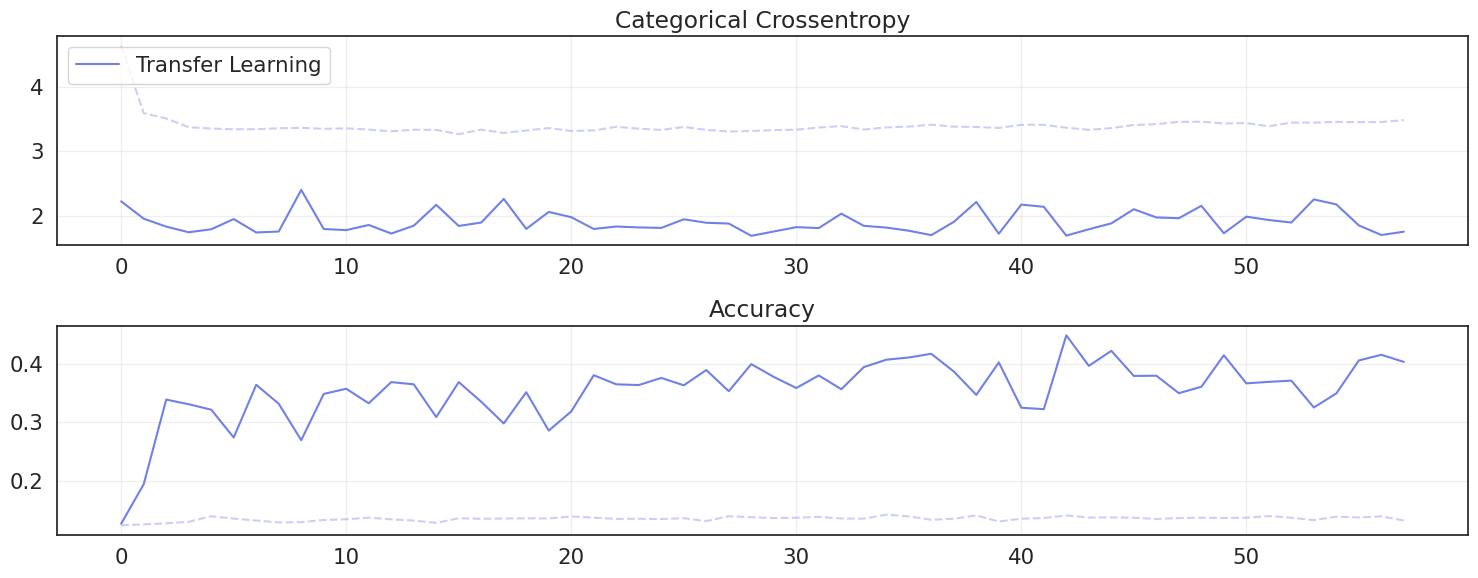

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot loss for both re-trained and transfer learning models
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both re-trained and transfer learning models
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.set_title('Accuracy')
ax2.grid(alpha=0.3)

# Adjust layout to prevent label overlap and display the plots
plt.tight_layout()
plt.show()

### INFERENCE

Predictions Shape: (2796, 8)
Accuracy score over the test set: 0.4467
Precision score over the test set: 0.4908
Recall score over the test set: 0.4467
F1 score over the test set: 0.4249


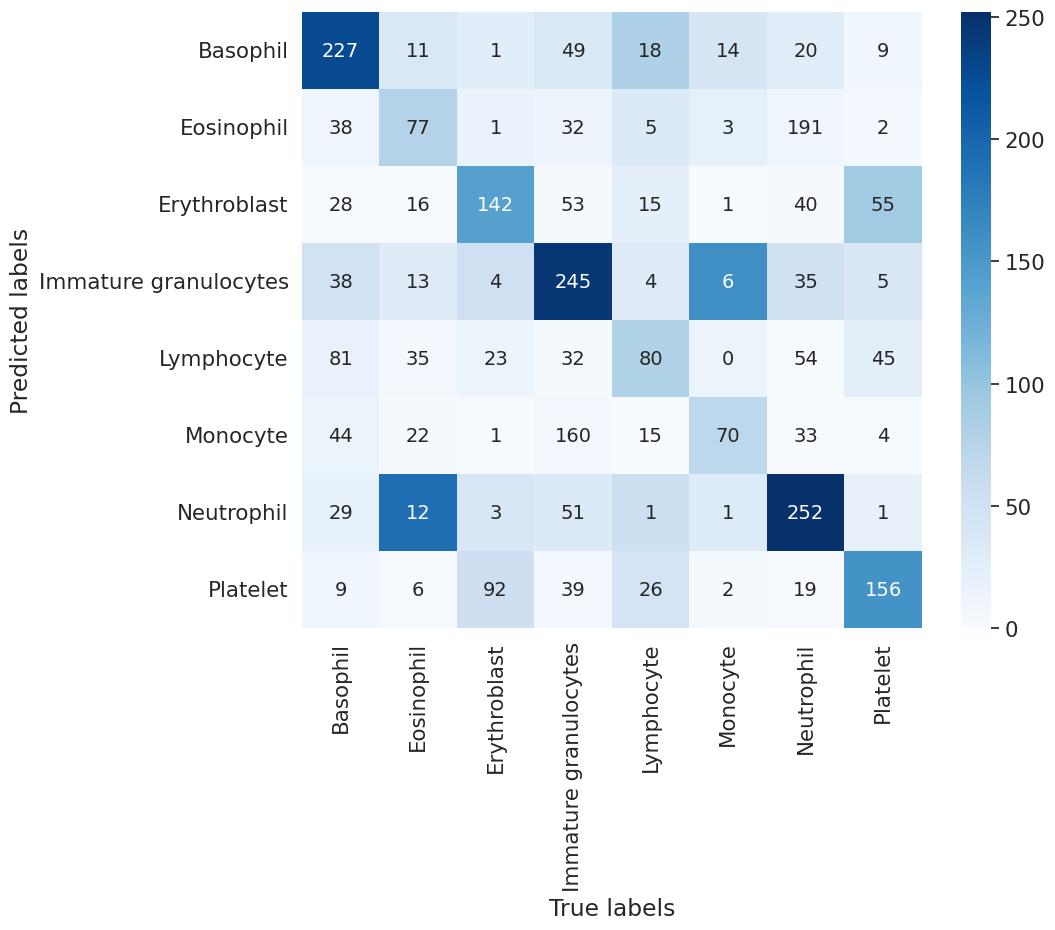

In [ ]:
# Load the saved model
model_filename = "InceptionV3_TL_44.85.keras"
model = tfk.models.load_model(model_filename)

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

del model

## 🛠️ FINE TUNING

## 🧮 Define Network Parameters

In [ ]:
# Learning rate
initial_learning_rate = 1e-4
ft_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

# Optimazer
ft_Lion_optimizer = tfk.optimizers.Lion(learning_rate=ft_lr_schedule)

# Number of training epochs
ft_epochs = 70

# Batch size for training
ft_batch_size = 128

# Patience
ft_patience = 10


# Create an EarlyStopping callback
ft_callbacks = [
    tfk.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=ft_patience,
        restore_best_weights=True
    ),
    tfk.callbacks.ModelCheckpoint(
        filepath='best.weights.h5',
        save_best_only=True,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
]

## 🛠️ Build the Model

In [ ]:
# Load the model
model_filename = "InceptionV3_TL_44.85.keras"
ft_model = tfk.models.load_model(model_filename)

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('inception_v3').layers[-15:]):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=ft_Lion_optimizer, metrics=['accuracy'])

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ TRAINING

In [ ]:
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = ft_batch_size,
    epochs = ft_epochs,
    validation_data = (X_val, y_val),
    callbacks = ft_callbacks,
    verbose = 2
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'InceptionV3_FT_'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/70

Epoch 1: val_accuracy improved from -inf to 0.32814, saving model to best.weights.h5
106/106 - 59s - 552ms/step - accuracy: 0.1345 - loss: 2.8403 - val_accuracy: 0.3281 - val_loss: 2.2185
Epoch 2/70

Epoch 2: val_accuracy improved from 0.32814 to 0.37274, saving model to best.weights.h5
106/106 - 47s - 447ms/step - accuracy: 0.1381 - loss: 2.5595 - val_accuracy: 0.3727 - val_loss: 1.7630
Epoch 3/70

Epoch 3: val_accuracy improved from 0.37274 to 0.39840, saving model to best.weights.h5
106/106 - 82s - 774ms/step - accuracy: 0.1404 - loss: 2.4764 - val_accuracy: 0.3984 - val_loss: 1.7261
Epoch 4/70

Epoch 4: val_accuracy did not improve from 0.39840
106/106 - 79s - 749ms/step - accuracy: 0.1425 - loss: 2.4133 - val_accuracy: 0.3891 - val_loss: 1.7046
Epoch 5/70

Epoch 5: val_accuracy improved from 0.39840 to 0.42659, saving model to best.weights.h5
106/106 - 84s - 792ms/step - accuracy: 0.1405 - loss: 2.3849 - val_accuracy: 0.4266 - val_loss: 1.6121
Epoch 6/70

Epoch 6: val_

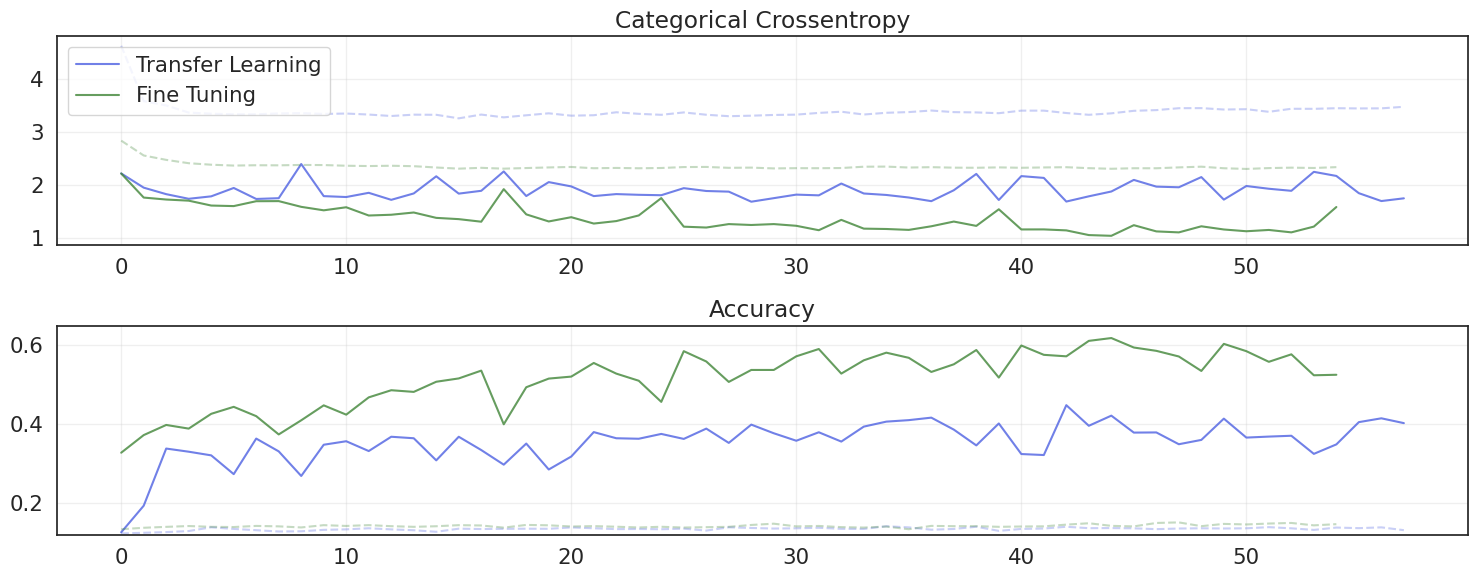

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

## INFERENCE

Predictions Shape: (2796, 8)
Accuracy score over the test set: 0.6241
Precision score over the test set: 0.644
Recall score over the test set: 0.6241
F1 score over the test set: 0.6169


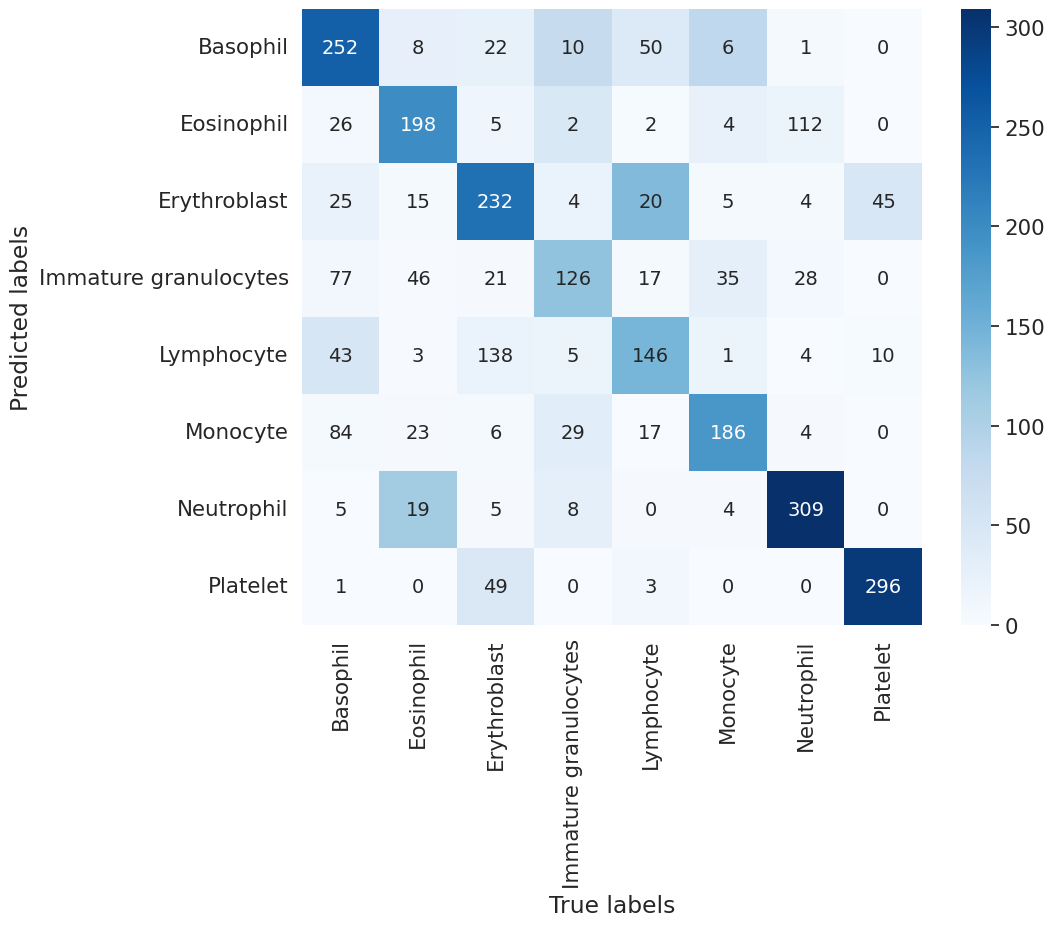

In [ ]:
# Load the saved model
model_filename = "InceptionV3_FT_61.84.keras"
model = tfk.models.load_model(model_filename)

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

##SUBMISSION

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model("InceptionV3_FT_61.84.keras")

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py InceptionV3_FT_61.84.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 55%)
  adding: InceptionV3_FT_61.84.keras (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>